In [10]:
%run 3.inference.ipynb

Aresta [-55, 2, 17, 0.3] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-85, 3.8, 30, 0.1] -> Classe 1 (Bom) (confiança 0.66)
Aresta [-35, 1.2, 5, 0.05] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-88, 9.5, 95, 0.9] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-40, 8.2, 85, 0.8] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-87, 1.5, 8, 0.15] -> Classe 1 (Bom) (confiança 0.99)
Aresta [-62, 2.8, 32, 0.28] -> Classe 1 (Bom) (confiança 0.96)
Aresta [-58, 3.2, 28, 0.32] -> Classe 1 (Bom) (confiança 0.96)
Aresta [-52, 2.1, 20, 0.25] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-48, 2.5, 25, 0.22] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-50, 1.8, 22, 0.28] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-75, 5.2, 65, 0.6] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-78, 4.8, 70, 0.65] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-72, 5.5, 60, 0.58] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-45, 4.5, 15, 0.7] -> Classe 0 (Ruim) (confiança 0.56)
Aresta [-70, 1.9, 45, 0.2] -> Classe 1 (Bom) (confiança 0.9

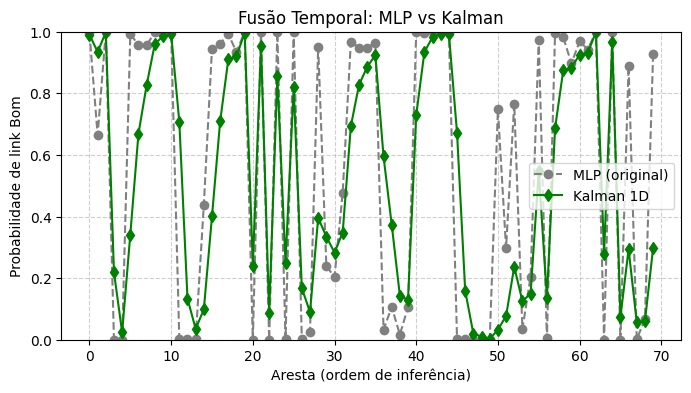


Saída com Kalman:
Aresta 0: MLP=1.00 | Kalman=0.99 -> Classe 1 (Bom)
Aresta 1: MLP=0.66 | Kalman=0.93 -> Classe 1 (Bom)
Aresta 2: MLP=1.00 | Kalman=1.00 -> Classe 1 (Bom)
Aresta 3: MLP=0.00 | Kalman=0.22 -> Classe 0 (Ruim)
Aresta 4: MLP=0.00 | Kalman=0.02 -> Classe 0 (Ruim)
Aresta 5: MLP=0.99 | Kalman=0.34 -> Classe 0 (Ruim)
Aresta 6: MLP=0.96 | Kalman=0.67 -> Classe 1 (Bom)
Aresta 7: MLP=0.96 | Kalman=0.83 -> Classe 1 (Bom)
Aresta 8: MLP=1.00 | Kalman=0.96 -> Classe 1 (Bom)
Aresta 9: MLP=1.00 | Kalman=0.98 -> Classe 1 (Bom)
Aresta 10: MLP=1.00 | Kalman=0.99 -> Classe 1 (Bom)
Aresta 11: MLP=0.00 | Kalman=0.71 -> Classe 1 (Bom)
Aresta 12: MLP=0.00 | Kalman=0.13 -> Classe 0 (Ruim)
Aresta 13: MLP=0.00 | Kalman=0.04 -> Classe 0 (Ruim)
Aresta 14: MLP=0.44 | Kalman=0.10 -> Classe 0 (Ruim)
Aresta 15: MLP=0.95 | Kalman=0.40 -> Classe 0 (Ruim)
Aresta 16: MLP=0.96 | Kalman=0.71 -> Classe 1 (Bom)
Aresta 17: MLP=0.99 | Kalman=0.91 -> Classe 1 (Bom)
Aresta 18: MLP=0.93 | Kalman=0.92 -> Classe 1 (B

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 2) Filtro de Kalman 1D (no logit)
# -------------------------------
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class Kalman1D:
    def __init__(self, Q=0.05, R=0.25):
        """
        Q = variância do processo (quão rápido o estado pode mudar)
        R = variância da observação (ruído da medição)
        """
        self.Q = Q
        self.R = R
        self.z_est = 0.0   
        self.P = 1.0       

    def update(self, p_now):
        y = logit(p_now)

        # predição
        z_pred = self.z_est
        P_pred = self.P + self.Q

        # ganho de Kalman
        K = P_pred / (P_pred + self.R)

        # atualização
        self.z_est = z_pred + K * (y - z_pred)
        self.P = (1 - K) * P_pred

        # retorna probabilidade suavizada
        return sigmoid(self.z_est)

# -------------------------------
# 3) Série de probabilidades do MLP (classe "Bom")
# -------------------------------
prob_ml_series = probs[:, 1].numpy()

# -------------------------------
# 4) Aplicar Kalman
# -------------------------------
kf = Kalman1D(Q=0.05, R=0.25)
prob_kalman = [kf.update(p) for p in prob_ml_series]

# -------------------------------
# 5) Plot comparativo
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(prob_ml_series, 'o--', label="MLP (original)", color="gray")
plt.plot(prob_kalman,  'd-',  label="Kalman 1D",      color="green")
plt.title("Fusão Temporal: MLP vs Kalman")
plt.xlabel("Aresta (ordem de inferência)")
plt.ylabel("Probabilidade de link Bom")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# -------------------------------
# 6) Decisão final pós-Kalman
# -------------------------------
tau = 0.5
y_pred_kf = (np.array(prob_kalman) >= tau).astype(int)

CLASS_NAMES = {0: "Ruim", 1: "Bom"}
print("\nSaída com Kalman:")
for i, (p_raw, p_kf, c) in enumerate(zip(prob_ml_series, prob_kalman, y_pred_kf)):
    print(f"Aresta {i}: MLP={p_raw:.2f} | Kalman={p_kf:.2f} -> Classe {c} ({CLASS_NAMES[c]})")
